# Random forest importance

In [3]:
%store -r X_256
%store -r y_256
%store -r X_test_256
%store -r y_test_256
%store -r feature_names_256

In [4]:
# Import thư viện
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [5]:
import matplotlib.pyplot as plt

# Reshape data
# Data ban đầu X(13166, 20, 128), y(13166)

# Reshape X về dạng 2d => X_2d(263320, 128), giữ nguyên 128 và đó là các đặc trưng
X_2d = X_256.reshape(-1, X_256.shape[-1])
# Reshape y thành y_reshaped(263320) bằng cách lặp mỗi phần tử trong y 20 lần
y_reshaped = np.repeat(y_256, 20)

In [6]:
# Khởi tạo mô hình Random Forest
model = RandomForestClassifier(n_estimators=500)
# Nó chỉ định số lượng cây quyết định sẽ được xây dựng và kết hợp để tạo thành khu rừng ngẫu nhiên trong thuật toán random forest.

In [7]:
# Huấn luyện mô hình
model.fit(X_2d, y_reshaped)

RandomForestClassifier(n_estimators=500)

In [8]:
# Lấy tầm quan trọng của đặc trưng
feature_importances = model.feature_importances_

# In tầm quan trọng của đặc trưng
print(feature_importances)

[0.01503774 0.01203503 0.01146778 0.01092988 0.01149734 0.01158215
 0.01126706 0.01135446 0.01135322 0.01143482 0.01136694 0.01111469
 0.01833588 0.02711556 0.02591704 0.02848385 0.02134692 0.02854696
 0.02391265 0.02194309 0.0142512  0.01712228 0.01427856 0.01746605
 0.01411969 0.01247185 0.01309137 0.01435145 0.01022458 0.00700235
 0.0066024  0.00380909 0.00394143 0.00347498 0.00334831 0.00340025
 0.00272114 0.00284036 0.00268756 0.00392304 0.00301731 0.00311554
 0.00368049 0.00321368 0.00320313 0.00229897 0.00307679 0.00266055
 0.00274789 0.00273806 0.00228004 0.00291933 0.00278604 0.0028598
 0.00281175 0.00327096 0.0038128  0.00397542 0.00343503 0.00443022
 0.00573386 0.00524167 0.00553307 0.00348255 0.00322096 0.00404111
 0.00352748 0.00289476 0.0032587  0.00311958 0.00408184 0.00375123
 0.00326049 0.00362627 0.00347764 0.00266642 0.00310268 0.00264634
 0.00352021 0.00369787 0.00378057 0.00350601 0.00327828 0.00334321
 0.00335675 0.00290824 0.00234565 0.00237799 0.00206948 0.00194

In [9]:
feature_importances.shape

(256,)

In [10]:
feature_names_256

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '246', '247', '248', '249', '250', '251', '252', '253', '254', '255'],
      dtype='object', length=256)

In [11]:
# Tạo dataframe gồm tên đặc trưng và tầm quan trọng
feature_importances_df = pd.DataFrame({"feature_name": feature_names_256, "importance": feature_importances})

# Sắp xếp dataframe theo tầm quan trọng
feature_importances_df = feature_importances_df.sort_values("importance", ascending=False)

# Lấy index của dataframe
indices = feature_importances_df.index

# In index
print(indices)

Index([ 17,  15,  13,  14,  18,  19,  16,  12,  23,  21,
       ...
       217, 190, 200, 201, 215, 212, 196, 197, 227, 202],
      dtype='int64', length=256)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6580\1610770524.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=indices, y='importance', data=feature_importances_df, palette='Blues_d')


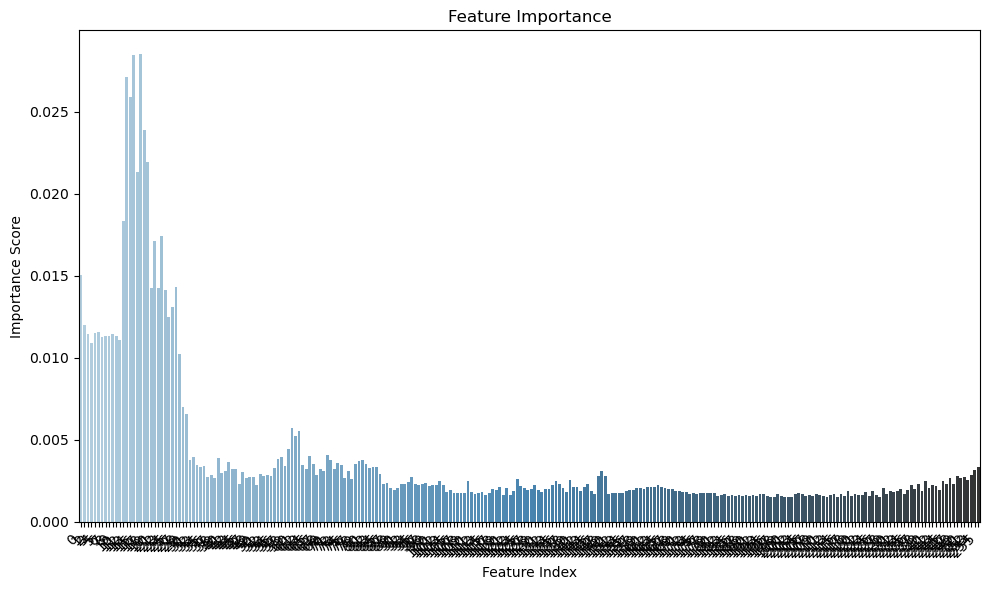

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=indices, y='importance', data=feature_importances_df, palette='Blues_d')
plt.xticks(indices, feature_importances_df['feature_name'], rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

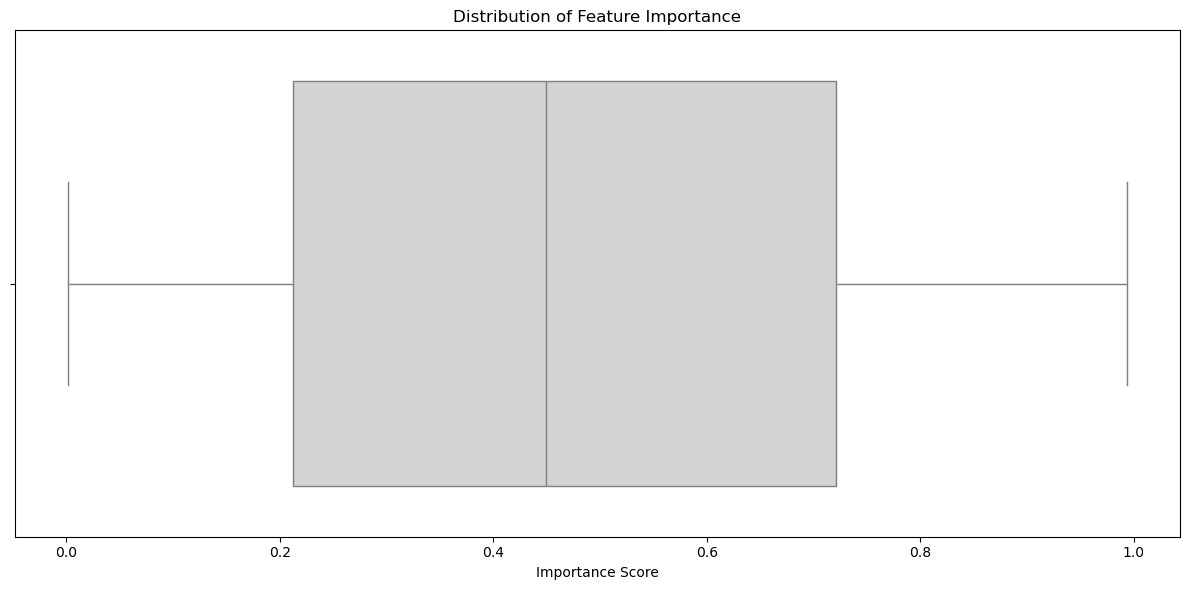

In [52]:
# Vẽ biểu đồ hộp với Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x=feature_importances_df["importance"], color='lightgray')
plt.xlabel('Importance Score')
plt.title('Distribution of Feature Importance')
plt.tight_layout()
plt.show()


In [42]:
# Xác định số đặc trưng sẽ giữ lại để train  model
k = 128
top_k_indices = indices[:k]

In [13]:
# Giữ lại k đặc trưng tốt nhất trong tệp dữ liệu ban đầu
selected_X = X_256[:,:,top_k_indices]
selected_X_test = X_test_256[:,:,top_k_indices]

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Khởi tạo mô hình
model = keras.Sequential()

model.add(layers.Input(shape = (20, k, 1)))

# Thêm lớp Convolutional Layer với 32 bộ lọc kích thước 5x5 và hàm kích hoạt ReLU
model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))

# Thêm lớp Convolutional Layer với 32 bộ lọc kích thước 5x5 và hàm kích hoạt ReLU
model.add(layers.Conv2D(32, (5,5), activation='relu', padding='same'))

# Thêm lớp Max Pooling 2D để giảm kích thước đầu vào đi 2 lần
model.add(layers.MaxPooling2D((2, 2)))

# Thêm lớp Dropout để giảm hiện tượng overfitting
model.add(layers.Dropout(0.5))

# Thêm lớp Convolutional Layer với 64 bộ lọc kích thước 3x3 và hàm kích hoạt ReLU
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))

# Thêm lớp Convolutional Layer với 64 bộ lọc kích thước 3x3 và hàm kích hoạt ReLU
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))

# Thêm lớp Max Pooling 2D để giảm kích thước đầu vào đi 2 lần
model.add(layers.MaxPooling2D((2, 2)))

# Thêm lớp Flatten để làm phẳng đầu ra của lớp trước khi đi vào các lớp fully connected
model.add(layers.Flatten())

# Thêm lớp fully connected (Dense Layer) với 64 units và hàm kích hoạt ReLU
model.add(layers.Dense(64, activation='relu'))

# Thêm lớp Dropout để giảm hiện tượng overfitting
model.add(layers.Dropout(0.5))

# Thêm lớp fully connected (Dense Layer) cuối cùng với số lớp đầu ra phụ thuộc vào bài toán của bạn
model.add(layers.Dense(5, activation='softmax'))

# In thông tin mô hình
model.summary()

# Biên dịch mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 20, 128, 32)         │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 128, 32)         │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 64, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         655,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 835,941 (3.19 MB)

 Trainable params: 835,941 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.fit(selected_X, y_256, epochs=10, batch_size=16)

Epoch 1/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 79s 93ms/step - accuracy: 0.4554 - loss: 1.2480
Epoch 2/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - accuracy: 0.7857 - loss: 0.5559
Epoch 3/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - accuracy: 0.8123 - loss: 0.4827
Epoch 4/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 71s 86ms/step - accuracy: 0.8356 - loss: 0.4391
Epoch 5/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - accuracy: 0.8408 - loss: 0.4042
Epoch 6/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 78s 95ms/step - accuracy: 0.8552 - loss: 0.3757
Epoch 7/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - accuracy: 0.8549 - loss: 0.3621
Epoch 8/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 73s 88ms/step - accuracy: 0.8719 - loss: 0.3360
Epoch 9/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - accuracy: 0.8760 - loss: 0.3217
Epoch 10/10
823/823 ━━━━━━━━━━━━━━━━━━━━ 77s 94ms/step - accuracy: 0.8834 - loss: 0.3021


In [57]:
# Đánh giá mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(selected_X_test, y_test_256)
print("Độ chính xác trên tập kiểm tra:", test_accuracy)

# Dự đoán các nhãn trên tập kiểm tra
y_pred = model.predict(selected_X_test)

# Chuyển đổi dự đoán thành nhãn dự đoán (lớp dự đoán)
y_pred_classes = np.argmax(y_pred, axis=1)

# Hiển thị ma trận nhầm lẫn
from sklearn.metrics import confusion_matrix, classification_report
confusion = confusion_matrix(y_test_256, y_pred_classes)
print("Ma trận nhầm lẫn:")
print(confusion)

# Hiển thị báo cáo phân loại
class_report = classification_report(y_test_256, y_pred_classes, digits=4)
print("Báo cáo phân loại:")
print(class_report)

412/412 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9355 - loss: 0.1574
Độ chính xác trên tập kiểm tra: 0.9281482696533203
412/412 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step
Ma trận nhầm lẫn:
[[2842    0    0    0    0]
 [   0 1976    2   23   33]
 [   0   34 2474    0  300]
 [   1  336    8 1387    8]
 [   2   19  180    0 3541]]
Báo cáo phân loại:
              precision    recall  f1-score   support

           0     0.9989    1.0000    0.9995      2842
           1     0.8355    0.9715    0.8984      2034
           2     0.9287    0.8811    0.9042      2808
           3     0.9837    0.7971    0.8806      1740
           4     0.9122    0.9463    0.9289      3742

    accuracy                         0.9281     13166
   macro avg     0.9318    0.9192    0.9223     13166
weighted avg     0.9320    0.9281    0.9278     13166



In [17]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def micro_metrics(y_true, y_pred):
  # Calculate micro averages
  micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
      y_true, y_pred.argmax(axis=1), average='micro'
  )
    
  # Macro averages
  macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
      y_true, y_pred.argmax(axis=1), average='macro'
  )
  return {
      'micro_precision': micro_precision,
      'micro_recall': micro_recall,
      'micro_f1': micro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'macro_f1': macro_f1
  }

In [18]:
from tabulate import tabulate
micro_results = micro_metrics(y_test_256, y_pred)
# Prepare table data
table_data = [
  ["Micro Precision", micro_results['micro_precision']],
  ["Micro Recall", micro_results['micro_recall']],
  ["Micro F1-score", micro_results['micro_f1']],
  ["Macro Precision", micro_results['macro_precision']],
  ["Macro Recall", micro_results['macro_recall']],
  ["Macro F1-score", micro_results['macro_f1']],
]

# Print the table using tabulate
print(tabulate(table_data, headers=["Metric", "Score"]))

Metric              Score
---------------  --------
Micro Precision  0.928148
Micro Recall     0.928148
Micro F1-score   0.928148
Macro Precision  0.931798
Macro Recall     0.91919
Macro F1-score   0.922328
